---
title: Auditing Bias
author: Omar Armbruster
date: '2025-03-12'
image: "images.jpg"
description: Analyzing Implicit Bias in Machine Learning Models
format: html
execute:
    message: false
    warning: false
---

# Introduction
Machine learning models show potential to revolutionize automated decision-making processes and have already made their way into many of our daily lives through technologies like personalized recommendations, face identification, and self-driving cars. However, these models can also pose extreme dangers, as the models are only as good as the data they are trained on and can very easily reinforce existing injustices in our society. Even when certain traits like race are omitted from the training process, models can predict these traits from other features and still reinforce societal norms that we are trying to avoid. We demonstrate this by training a Decision Tree Classifier model on a dataset of responses to the 2018 Public Use Microdata Sample survey in New York and use it to predict whether an individual is likely to employed. We omit race from our training features and then audit our model to determine if it is truly independent from race. We examine three methods of fairness: calibration, error rate balance, and statistical parity, as well as examine feasible false negative and false positive rates.

We begin by importing the folktables package, which we use to import our data. We specify that we are examining responses from 2018 in the state of New York when fetching our data.

In [2]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np

STATE = "NY"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2018GQ0000012,2,1,3802,1,36,1013097,145,26,...,146,146,21,24,266,263,21,146,265,144
1,P,2018GQ0000040,2,1,2702,1,36,1013097,43,21,...,6,42,43,7,40,6,43,40,42,6
2,P,2018GQ0000060,2,1,2001,1,36,1013097,88,18,...,88,163,161,162,87,12,162,88,87,88
3,P,2018GQ0000081,2,1,2401,1,36,1013097,109,85,...,17,15,111,107,17,196,109,200,198,111
4,P,2018GQ0000103,2,1,1400,1,36,1013097,83,19,...,81,12,80,154,12,80,12,83,152,154


For the sake of simplicity, we can select specific features to train our model on. We select the following:

* AGEP - Age
* SCHL - Educational attainment
* MAR - Marital status
* RELP - Relationship to reference person
* DIS - Disability 
* ESP - Employment status of parents
* CIT - Citizenship stats
* MIG - Mobility status
* MIL - Military service
* ANC - Ancestry
* NATIVITY - Nativity 
* DEAR - Hearing difficulty
* DEYE - Vision difficulty
* DREM - Cognitive difficulty
* SEX - Sex
* RAC1P - Race
* ESR - Employment status 

In [3]:
possible_features=['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
acs_data[possible_features].head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,26,21.0,5,17,2,NaN,5,1.0,4.0,1,2,2,2,2.0,2,1,6.0
1,21,20.0,5,17,2,NaN,1,3.0,4.0,1,1,2,2,2.0,1,1,1.0
2,18,16.0,5,17,2,NaN,2,3.0,4.0,1,1,2,2,2.0,2,8,6.0
3,85,16.0,2,16,1,NaN,1,1.0,4.0,4,1,1,2,1.0,2,1,6.0
4,19,19.0,5,17,2,NaN,1,1.0,4.0,2,1,2,2,2.0,2,1,1.0


We use the selected features to define our training dataset but exclude employment status (the target variable) and race, which we claim the model will be able to implicitly determine. We define a problem, which specifies our target and hidden features (employment and race).

Looking briefly at our data, it appears we have $196,967$ observations (people) measured with $15$ features. We confirm that our created feature, label, and group objects all have the same length, as each entry should correspond to a single person.

In [4]:
features_to_use = [f for f in possible_features if f not in ["ESR", "RAC1P"]]
EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)

for obj in [features, label, group]:
  print(obj.shape)

(196967, 15)
(196967,)
(196967,)


As is good machine learning practice, we define a testing and training dataset so we can later evaluate how our model performs on unseen data.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

For later analysis, we create a function that modifies our training and testing datasets, which only include the training features. We add both the group (race) and label (employment status) columns to the new dataset as well as modify encoded labels to labels that we can understand. For the sake of analyzing sufficiently large racial groups, we sort groups into White, African American, Asian, and Other.

In [6]:
import pandas as pd
def format_data(df, features_to_use, group, labels):
    new_df = pd.DataFrame(df, columns = features_to_use)
    new_df['group'] = group
    new_df['employed'] = labels
    new_df['SEX'] = new_df['SEX'].replace({1.0: 'Male', 2.0: 'Female'})
    new_df['group'] = new_df['group'].replace({1.0: 'White', 
                                               2.0: 'African American',
                                               3.0: 'Other Race',
                                               4.0: 'Other Race',
                                               5.0: 'Other Race',
                                               6.0: 'Asian',
                                               7.0: 'Other Race',
                                               8.0: 'Other Race',
                                               9.0: 'Other Race'})

    return new_df

A quick examination of the training data shows that each of our racial groups are in the same order of magnitude with the exception of the White group, which has significantly more people in it.

In [7]:
df_train = format_data(X_train, features_to_use, group_train, y_train)
df_train.groupby('group').size()

group
African American     19200
Asian                13633
Other Race           13904
White               110836
dtype: int64

Using this dataframe, we can determine the population of the training dataset, which we find to be $157573$ people.

In [8]:
population = df_train.shape[0]
population

157573

Of these individuals, roughly $46.5\%$ people are employed. This rate is likely so low because we included children in our data, the majority of whom are unemployed.

In [9]:
df_train['employed'].mean()

0.4649400595279648

We can also analyze the proportion of each race in our population. As we saw in the population counts above, African Americans, Asians, and Other Racial groups each make up a similar amount of the population with $11.0\%$, $9.3\%$, and $7.9\%$ respectively, while White people make up the remaining $71.8\%$ of the population.

In [10]:
df_train[df_train['employed'] == 1].groupby('group').size()/df_train[df_train['employed'] == 1].shape[0]

group
African American    0.109607
Asian               0.092517
Other Race          0.079277
White               0.718599
dtype: float64

Despite variances in the size of each racial group, we observe roughly equal employment rates across groups such that $41.8\%$ of African Americans are employed, $49.7\%$ of Asians are employed, $47.5\%$ of Whites are employed, and $41.8\%$ of individuals in other racial groups are employed. These values will be important later for when we audit our model to determine how consistent the predicted employment rates are with reality.

In [11]:
df_train.groupby('group')['employed'].mean()

group
African American    0.418229
Asian               0.497176
Other Race          0.417722
White               0.474990
Name: employed, dtype: float64

It is also worth checking for intersectional trends by examining what percentage of people are employed grouped by sex as well as race. This can help us determine if race is the only major factor in disparities between groups or if there are other contributing factors. Based on the bar plot below, it appears that a greater proportion of men than women are employed with the exception of the African American group. This indicates that women within each racial group may receive further bias from the algorithm, as it is possible that it will predict unemployment for women at higher rates. This may be more prevalent than bias by race since sex is actually a feature that we give to the model wheras race is not.

[Text(0.5, 1.0, 'Intersection between race and sex'),
 Text(0.5, 0, 'Race'),
 Text(0, 0.5, 'Proportion of group employed')]

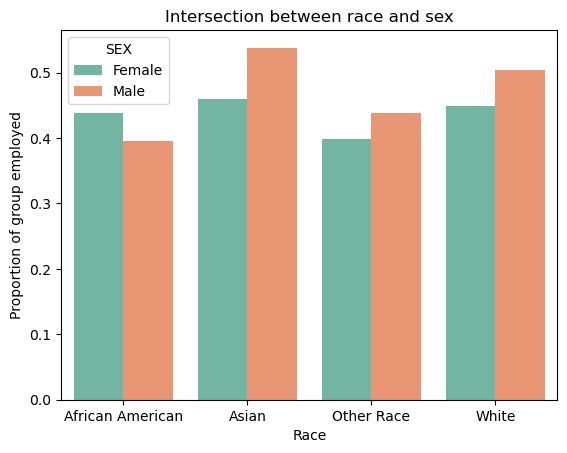

In [27]:
import seaborn as sns
import seaborn.objects as so

prop = (df_train[df_train['employed'] == 1].groupby(['group', 'SEX']).size()/df_train.groupby(['group', 'SEX']).size()).reset_index(name = 'p')
p1 = sns.barplot(data = prop,
                 x = 'group',
                 y = 'p',
                 hue = 'SEX',
                 palette='Set2')
p1.set(title = 'Intersection between race and sex', xlabel = 'Race', ylabel = 'Proportion of group employed')

# Fitting a Model
Now to train our model. We have chosen to use a Decision Tree Classifer Model. We use the Standard Scaler to make sure each of our features are weighted equally when training our model.

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In order to use Decision Tree Classifier, we need to tune the max_depth parameter. We can do this very elegantly by trying every possible depth from $1$ to $100$ and choosing the model which scores the most accurately on the data. From this approach, we find that the optimal depth is $10$. Nice!

In [14]:
max_depths = np.linspace(1, 100, 100)
best_depth = 1
best_val = 0
best_model = DecisionTreeClassifier(max_depth = 1)
for depth in max_depths:
    DTC = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth = int(depth)))
    DTC.fit(X_train, y_train)
    val = cross_val_score(DTC, X_train, y_train, cv = 5).mean()
    if val > best_val:
        best_val = val
        best_depth = depth
        best_model = DTC
print("Best Depth: {}".format(best_depth))




Best Depth: 10.0


# Auditing the model
Now that we've trained our model, we want to audit our model for implicit biases that it may have picked up from the data. We can first examine some overall features of the model and then examine those features by group to see where differences may be occuring.
## Overall Measures
We can first format our data as we did with the training set and then calculat ethe prediction accuracy. Our model appears to guess employment status correctly $82.4\%$ of the time.

In [15]:
df = format_data(X_test, features_to_use, group_test, y_test)
df['pred_employed'] = best_model.predict(X_test)
df['correct_prediction'] = (df['employed'] == df['pred_employed'])
# Prediction Accuracy
df['correct_prediction'].mean()

0.8237802711072753

To break down where the model went wrong, we can exmaine the number of correct positive and negative predictions as well as incorrect positive and negative predictions. It appears that our model tends to incorrectly guess that a given employee is employed rather than unemployed, indicated by the $4474$ false positive (FP) guesses and the $2472$ false negative (FN) guesses.

In [16]:
df['TN'] = (df['employed'] == 0) & (df['pred_employed'] == 0)
df['TP'] = (df['employed'] == 1) & (df['pred_employed'] == 1)
df['FN'] = (df['employed'] == 1) & (df['pred_employed'] == 0)
df['FP'] = (df['employed'] == 0) & (df['pred_employed'] == 1)
df[['TN', 'TP', 'FN', 'FP']].sum()

TN    16719
TP    15733
FN     2474
FP     4468
dtype: int64

Using these values we can calculate the positive predictive value (PPV), which is defined by $$PPV = \frac{TP}{TP + FP}$$ as well as the false positive rate $$FPR = \frac{FP}{FP + TN}$$ and false negative rate $$FNR = \frac{FN}{FN + TP}$$. We find these values to be $77.9\%$, $21.1\%$, and $13.6\%$ respectively.

In [17]:
PPV = df['TP'].sum() / (df['TP'].sum() + df['FP'].sum())
FPR = df['FP'].sum()/(df['FP'].sum() + df['TN'].sum())
FNR = df['FN'].sum()/(df['FN'].sum() + df['TP'].sum())
print(PPV, FPR, FNR)

0.7788228305529429 0.21088403266153774 0.13588180370187292


## By-Group Measures
We can now look at the same quantities as above but sorted by group. Starting with accuracy, we notice that the model seems to be fairly consistent in its predictions with the exception of Asians who are only predicted correctly $80.0\%$ of the time compares to the other groups who are predicted correctly roughly $82\%$ of the time.

In [18]:
df.groupby("group")['correct_prediction'].mean()

group
African American    0.820896
Asian               0.795996
Other Race          0.831117
White               0.826760
Name: correct_prediction, dtype: float64

We calculate the positive and negative counts as by group as well, which we will need for our PPV, FPR, and FNR values. 

In [19]:
df.groupby('group')[['TP', 'TN', 'FP', 'FN']].sum()

,TP,TN,FP,FN
group,,,,
African American,1800,2160,574,290
Asian,1539,1165,537,156
Other Race,1290,1648,402,195
White,11104,11746,2955,1833


Calculating the PPVs, we find that the values are fairly consistent with the White group having the highest value of $79.0\%$ and the Asian group having the lowest predictive value of $74.1\%$. This means that $79.0\%$ of the White people that are predicted to be employed are actually employed and $74.1\%$ of the Asian people that are predicted to be employed are actually employed.

In [20]:
PPV = df.groupby('group')['TP'].sum() / (df.groupby('group')['TP'].sum() + df.groupby('group')['FP'].sum())
PPV

group
African American    0.758214
Asian               0.741329
Other Race          0.762411
White               0.789814
dtype: float64

Calculating the FPR, we find that Asians are falsly predicted to be employed at a much higher rate than other groups with an FPR of $31.6\%$. The reamining groups all have FPR values of roughly $20\%$, indicating that our model may have a bias towards the Asian group. 

In [21]:
FPR = df.groupby('group')['FP'].sum()/(df.groupby('group')['FP'].sum() + df.groupby('group')['TN'].sum())
FPR

group
African American    0.209949
Asian               0.315511
Other Race          0.196098
White               0.201007
dtype: float64

The FNR rates closely resemble the trends seen in the FPR values, with each group having a value of roughly $13.5\%$ with the exception fo the Asian group, which has an FNR of $9.2\%$. This reinforces our observation that the model tends to overestimate the employment rate of the Asian group relative to the other groups.

In [22]:
FNR = df.groupby('group')['FN'].sum()/(df.groupby('group')['FN'].sum() + df.groupby('group')['TP'].sum())
FNR

group
African American    0.138756
Asian               0.092035
Other Race          0.131313
White               0.141687
dtype: float64

## Bias Measures
In order to check for bias, we can evaluate our model based on three standards: calibration, error rate balance, and statistical parity.

We can first examine calibration. A model is well calibrated if the prediction rates are consistent with the actual rates across racial groups. If we were to exclude the Asian group, we could say that our model is approximately calibrated. However, the Asian group has a significantly higher prediction rate than actual rate of employment, indicating poor calibration.

In [23]:
# Calibration
employed = df.groupby('group')['employed'].mean()
predicted_employed = df.groupby('group')['pred_employed'].mean()
pd.concat((predicted_employed, employed), axis = 1, keys = ['Prediction', 'True Rate'])

,Prediction,True Rate
group,,
African American,0.492123,0.433250
Asian,0.611127,0.498970
Other Race,0.478642,0.420085
White,0.508684,0.468087


Next we examine error rate parity, which evaluates if the FPR and FNR values are consistent with one another across groups. As with the calibration, three of the groups are fairly consistent with their FPR and FNR values, while the Asian group has a substantially higher FPR and a substantially lower FNR, indicating a poor error rate parity as well.

In [24]:
# Error Rate Parity
pd.concat((FPR, FNR), axis = 1, keys = ['FPR', 'FNR'])

,FPR,FNR
group,,
African American,0.209949,0.138756
Asian,0.315511,0.092035
Other Race,0.196098,0.131313
White,0.201007,0.141687


Lastly we can check for statistical parity, which examines if the predicted employment rates between groups are equal to one another. A model that satisfies statistical parity would have an equal proportion of people predicted to be employed across each group. Our model also does not satisfy statistical parity, as the predicted rate of Asian employment is signficantly higher than the rate for the three other racial groups.

In [25]:
# Statistical Parity 
df.groupby('group')['pred_employed'].mean()

group
African American    0.492123
Asian               0.611127
Other Race          0.478642
White               0.508684
Name: pred_employed, dtype: float64

Based on the paper "Fair Prediction with Disparate Impact: A Study of Bias in Recidivism Prediction Instruments." by Alexandra Chouldechova, we can examine how fair our model has the potential to be by finding the optimal combinations of FNR and FPR rates. We can calculate the FPR using the FNR with the equation $$FPR = \frac{p}{1 - p}\frac{1 - PPV}{PPV}(1 - FNR)$$ where $p$ is the prevalence or actual employment rate. As an approximation to calibrate our results, we set the PPV to be the minimum PPV value between groups. In this case, we are only examining the White and Asian groups, so we use the Asian PPV as our value. We can add shading to the White line, which shows acceptable FPR values for the White group if we allow the the PPV of the White group to deviate by $\delta = 0.5$, $0.1$, and $0.125$ from the PPV of the Asian group. Based on the plot, if we desired to tune our classifier threshold so that the false positive rates were equal between races, we would need to increase the false negative rate of the Asian group to roughly $0.2$. This is not a substantial change, indicating that we could achieve a fair outcome without much of a decrease in the accuracy of the model.

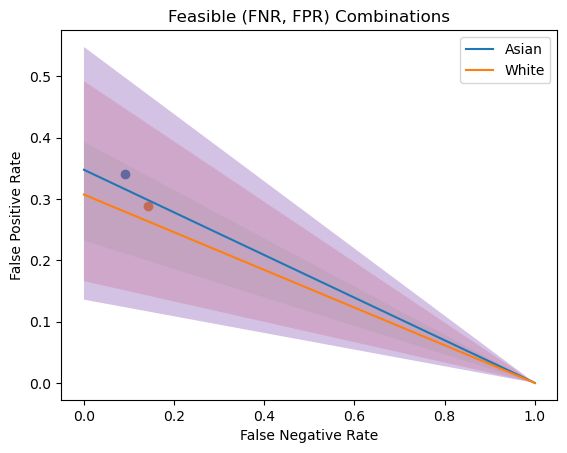

In [26]:
import matplotlib.pyplot as plt
PPV_min = PPV[['Asian', 'White']].min()
p = df.groupby('group')['employed'].mean()
FNR_calc = np.linspace(0, 1, 50)
FPR_calc = lambda p,FNR, PPV_min: (p/(1-p)) * ((1 - PPV_min)/PPV_min)*(1 - FNR)
FPRs = [FPR_calc(ps, FNR_calc, PPV_min) for ps in p]
for i, FPR in enumerate(FPRs):
    if(p.index[i] in ['Asian', 'White']):
        plt.plot(FNR_calc, FPR, label = p.index[i])
        plt.scatter(FNR[i], FPR[i])
plt.fill_between(FNR_calc, FPR_calc(p['White'], FNR_calc, PPV_min -0.05),FPR_calc(p['White'], FNR_calc, PPV_min +0.05), alpha = 0.1)
plt.fill_between(FNR_calc, FPR_calc(p['White'], FNR_calc, PPV_min -0.1),FPR_calc(p['White'], FNR_calc, PPV_min +0.1), alpha = 0.2)
plt.fill_between(FNR_calc, FPR_calc(p['White'], FNR_calc, PPV_min -0.125),FPR_calc(p['White'], FNR_calc, PPV_min +0.125), alpha = 0.4)
plt.xlabel('False Negative Rate')
plt.ylabel('False Positive Rate')
plt.title('Feasible (FNR, FPR) Combinations')
plt.legend()

# Conclusion
1. The discussion of employment prediction has numerous practical applications that could benefit or harm specific groups. For instance, landlords and bankers may want to be able to use this algorithm to determine whether or not to rent or give a loan to someone, as an employed person would be more likely to be able to make their payments on time. 
2. Based on our bias audit, this could be potentially harmful to certain groups, as we observed that certain groups were predicted to be employed at much higher rates than the other groups and also than the real employment rate. This could provide unfair advantages and disadvantages to specific groups based simply on their race. This is particularly troubling given that the actual rates of employment were fairly consistent between groups. If we were to deploy this on a large scale, our model could potentially enforce inequality between races and make it more difficult for certain groups to obtain necessary resources like a place to live or access to credit.
3. Based on our bias audit, our model displays problematic bias of all three types, failing to satisfy calibration, error rate balance, and statistical parity. While there was general agreement between three of our groups, our fourth group deviated heavily in all three measurements. If we were to deploy this model on a large scale, we would need to somehow alter our model to account for the disparity with this group. 
4. Besides potential bias, this model has the potential to make decisions that could harm large groups of people. For starters, this model is built on the idea that we can generalize a subset of the population to the entire population based on a very select number of features. This is not necessarily true and could lead to the model making generalizations and decisions about groups based on certain traits that we have not considered. One way we could counteract this is by giving the model more training data and selecting more features to train the model on. The other issue with this model is that the ending result: guessing employment, could very easily be used to make harmful decisions based on unfair assumptions. Based on the renter example, people that are unemployed or perhaps are just predicted to be unemployed could have harder times finding a home, even if they were able to pay their rent on time consistently. A predictive model like this would just make it harder for groups of people that are likely already struggling due to their lack of employment. Because of this, we need to be very careful when implementing decision-making algorithms on a large scale.